In [3]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
import deepchem
import tensorflow as tf
import pandas as pd
import pickle

import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test,create_dataset_for_test_bootstrap
import seaborn as sns


from statannotations.Annotator import Annotator #!pip install seaborn statannotations 

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
RDKit WARNING: [10:33:11] Enabling RDKit 2019.09.3 jupyter extensions
[10:33:11] Enabling RDKit 2019.09.3 jupyter extensions


## Testing the trained model on the entire testset

In [4]:
datasets = [['davis', 'kiba'][1]]
datasets 

['kiba']

In [14]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + '_pconcs4_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')

def calculate_metrics1(Y, P, dataset):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse,mse,rm2,spearman


def calculate_metrics2(Y, P):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse,mse,rm2,spearman

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


In [5]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][2]
method

'alpha_fold_cmaps'

In [6]:
models_dir = 'models_sample'
results_dir = 'results'


In [7]:
dataset = ['davis', 'kiba'][1]  # dataset selection
model_st = GNNNet.__name__
print('dataset:', dataset)
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0] # gpu selection
print('cuda_name:', cuda_name)

dataset: kiba
cuda_name: cuda:0


In [8]:
TEST_BATCH_SIZE = 128
#models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_alpha__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/result_alpha_1_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/Protein_ContactMaps_DL_BindingAffinity/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8467353470455949
cindex2 0.8440989879866547
rm2: 0.6403622830910014
mse: 0.23723707
pearson 0.8048234945707698
kiba
rmse:0.48706987797491885  mse:0.23723707  pearson:0.8048234945707698 spearman:0.8070897165383186 ci:0.8467353470455949 rm2:0.6403622830910014


In [9]:
TEST_BATCH_SIZE = 128
#models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_alpha_3__188_2000_GNNNet_kiba_2.model'
result_file_name = 'results/result_alpha_2_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y1, P1 = predicting(model, device, test_loader)
calculate_metrics(Y1, P1, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8510110275332209
cindex2 0.8496090902126671
rm2: 0.6189408306197125
mse: 0.23181702
pearson 0.8111916305074771
kiba
rmse:0.4814738019518617  mse:0.23181702  pearson:0.8111916305074771 spearman:0.8154122256572224 ci:0.8510110275332209 rm2:0.6189408306197125


In [10]:
torch.cuda.empty_cache()

In [11]:
TEST_BATCH_SIZE = 128
#models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_alpha_2__188_2000_GNNNet_kiba_3.model'
result_file_name = 'results/result_alpha_3_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y2, P2 = predicting(model, device, test_loader)
calculate_metrics(Y2, P2, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8524152587980554
cindex2 0.8496327534660119
rm2: 0.6514020025471596
mse: 0.22436634
pearson 0.81643383751588
kiba
rmse:0.47367323870040234  mse:0.22436634  pearson:0.81643383751588 spearman:0.8163856055521804 ci:0.8524152587980554 rm2:0.6514020025471596


In [15]:
Y

array([3.199999 , 3.6      , 3.4000006, ..., 4.4771214, 4.4771214,
       4.4771214], dtype=float32)

In [16]:
Y1

array([3.199999 , 3.6      , 3.4000006, ..., 4.4771214, 4.4771214,
       4.4771214], dtype=float32)

In [17]:
P

array([3.498755 , 3.6557398, 3.3054862, ..., 4.6206884, 4.156061 ,
       4.4513364], dtype=float32)

In [18]:
P1

array([3.4138284, 3.85346  , 3.5374653, ..., 4.3590975, 4.2023973,
       4.154314 ], dtype=float32)

In [34]:
P2

array([3.5411847, 3.7225807, 3.5913172, ..., 4.485827 , 4.106638 ,
       4.287121 ], dtype=float32)

In [24]:
pd

<module 'pandas' from '/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/pandas/__init__.py'>

In [13]:
import statistics
res = [np.mean(k) for k in zip(P,P1,P2)]

In [14]:
import statistics
res1 = [np.std(k) for k in zip(P,P1,P2)]

In [47]:
res

[3.4845893,
 3.743927,
 3.4780896,
 3.8879814,
 3.2974453,
 3.7227373,
 3.6216145,
 2.719487,
 2.81294,
 3.2629013,
 3.159251,
 2.7324772,
 3.9670296,
 3.1629708,
 3.8669567,
 3.2749016,
 3.9568071,
 2.8408623,
 3.7835371,
 3.9063148,
 3.207878,
 3.6687348,
 3.899141,
 3.4705274,
 3.8682766,
 3.8712394,
 3.2834466,
 3.1900864,
 3.3350384,
 3.6193142,
 3.8689067,
 3.2919657,
 2.9166205,
 4.6632867,
 2.4454367,
 4.067938,
 3.11005,
 4.3945208,
 3.1941965,
 3.5687199,
 2.3915415,
 2.6756554,
 3.9217072,
 3.9440937,
 3.5102978,
 3.6970043,
 3.1578197,
 3.3607047,
 3.843806,
 4.3452935,
 3.252053,
 3.829708,
 3.380579,
 2.587541,
 3.8967683,
 3.4943142,
 3.674866,
 3.7202938,
 3.6930306,
 3.0204697,
 1.7634825,
 3.3317568,
 3.5766506,
 3.573435,
 3.2908046,
 3.687436,
 1.9150567,
 3.707947,
 2.1450968,
 3.4092903,
 3.164067,
 2.206931,
 3.8114526,
 3.803587,
 3.633827,
 3.9016373,
 3.1886108,
 3.0463169,
 3.236972,
 3.7690897,
 3.811951,
 3.3633583,
 4.74532,
 4.2426248,
 3.8886626,
 2.7948

In [48]:
res1

[0.052949063,
 0.0821181,
 0.1240133,
 0.03411,
 0.121976204,
 0.059503715,
 0.054552667,
 0.31963828,
 0.16645838,
 0.45756277,
 0.07564473,
 0.08145311,
 0.061415993,
 0.0048093065,
 0.12716262,
 0.051585726,
 0.0040365336,
 0.18872394,
 0.0138853425,
 0.023692846,
 0.014105151,
 0.06995809,
 0.012363591,
 0.11687162,
 0.054600406,
 0.027521595,
 0.08285592,
 0.0033718885,
 0.023480259,
 0.0211525,
 0.026901063,
 0.088504925,
 0.059618626,
 0.08223498,
 0.7172155,
 0.1539288,
 0.01851382,
 0.1570869,
 0.0067179687,
 0.0150610125,
 0.45771584,
 0.07823441,
 0.0602403,
 0.017137026,
 0.03724294,
 0.017433377,
 0.05484074,
 0.07390151,
 0.057185188,
 0.16366091,
 0.09024788,
 0.25575805,
 0.09425863,
 0.6126351,
 0.01928643,
 0.043434896,
 0.058301568,
 0.12312866,
 0.022256972,
 0.3795206,
 0.19312122,
 0.033653587,
 0.08052951,
 0.20447573,
 0.03923124,
 0.008188375,
 0.30004558,
 0.03329357,
 0.23925522,
 0.054157034,
 0.03224868,
 0.4674795,
 0.1436171,
 0.112635136,
 0.12942365,
 0

In [44]:
[np.std(k) for k in zip(P,P1,P2)]

[0.052949063,
 0.0821181,
 0.1240133,
 0.03411,
 0.121976204,
 0.059503715,
 0.054552667,
 0.31963828,
 0.16645838,
 0.45756277,
 0.07564473,
 0.08145311,
 0.061415993,
 0.0048093065,
 0.12716262,
 0.051585726,
 0.0040365336,
 0.18872394,
 0.0138853425,
 0.023692846,
 0.014105151,
 0.06995809,
 0.012363591,
 0.11687162,
 0.054600406,
 0.027521595,
 0.08285592,
 0.0033718885,
 0.023480259,
 0.0211525,
 0.026901063,
 0.088504925,
 0.059618626,
 0.08223498,
 0.7172155,
 0.1539288,
 0.01851382,
 0.1570869,
 0.0067179687,
 0.0150610125,
 0.45771584,
 0.07823441,
 0.0602403,
 0.017137026,
 0.03724294,
 0.017433377,
 0.05484074,
 0.07390151,
 0.057185188,
 0.16366091,
 0.09024788,
 0.25575805,
 0.09425863,
 0.6126351,
 0.01928643,
 0.043434896,
 0.058301568,
 0.12312866,
 0.022256972,
 0.3795206,
 0.19312122,
 0.033653587,
 0.08052951,
 0.20447573,
 0.03923124,
 0.008188375,
 0.30004558,
 0.03329357,
 0.23925522,
 0.054157034,
 0.03224868,
 0.4674795,
 0.1436171,
 0.112635136,
 0.12942365,
 0

In [32]:
res

[3.4845893,
 3.7439268,
 3.4780896,
 3.8879814,
 3.2974453,
 3.7227373,
 3.6216145,
 2.719487,
 2.8129401,
 3.262901,
 3.1592507,
 2.7324774,
 3.9670293,
 3.162971,
 3.866957,
 3.2749019,
 3.9568071,
 2.8408623,
 3.7835374,
 3.9063146,
 3.207878,
 3.668735,
 3.8991408,
 3.4705274,
 3.8682764,
 3.8712392,
 3.2834468,
 3.1900864,
 3.3350387,
 3.6193142,
 3.8689065,
 3.2919657,
 2.9166205,
 4.6632867,
 2.4454367,
 4.067938,
 3.1100497,
 4.3945208,
 3.1941962,
 3.5687199,
 2.3915415,
 2.6756556,
 3.9217072,
 3.944094,
 3.5102978,
 3.6970043,
 3.1578195,
 3.360705,
 3.8438058,
 4.3452935,
 3.2520528,
 3.829708,
 3.3805792,
 2.587541,
 3.8967683,
 3.4943142,
 3.6748662,
 3.7202938,
 3.6930304,
 3.0204697,
 1.7634825,
 3.3317568,
 3.5766506,
 3.573435,
 3.2908046,
 3.6874363,
 1.9150567,
 3.707947,
 2.1450968,
 3.4092903,
 3.1640668,
 2.206931,
 3.8114526,
 3.803587,
 3.633827,
 3.901637,
 3.1886106,
 3.0463166,
 3.2369719,
 3.7690897,
 3.811951,
 3.363358,
 4.74532,
 4.2426248,
 3.8886626,
 

In [49]:
d = {'exp': Y, 'model1': P,'model2': P1,'model3': P2,'mean': res,'std': res1}
df = pd.DataFrame(data=d)
df

,exp,model1,model2,model3,mean,std
0,3.199999,3.498755,3.413828,3.541185,3.484589,0.052949
1,3.600000,3.655740,3.853460,3.722581,3.743927,0.082118
2,3.400001,3.305486,3.537465,3.591317,3.478090,0.124013
3,3.900000,3.842062,3.923740,3.898142,3.887981,0.034110
4,3.500000,3.362155,3.126610,3.403571,3.297445,0.121976
...,...,...,...,...,...,...
15903,2.700002,3.466819,3.744069,3.663186,3.624691,0.116414
15904,2.200002,2.194477,2.307308,2.099395,2.200393,0.084983
15905,4.477121,4.620688,4.359097,4.485827,4.488537,0.106811
15906,4.477121,4.156061,4.202397,4.106638,4.155032,0.039100


In [13]:
d = {'exp': Y, 'model1': P,'model2': P1,'model3': P2,'mean': res,'std': res1}
df = pd.DataFrame(data=d)
df

,exp,model1,model2,model3,mean,std
0,3.199999,3.501677,3.543769,3.350856,3.465434,0.082821
1,3.600000,3.707349,3.756871,3.630761,3.698327,0.051878
2,3.400001,3.415637,3.442379,3.623457,3.493824,0.092312
3,3.900000,3.878414,3.894676,3.838744,3.870611,0.023491
4,3.500000,3.222152,3.205805,3.291959,3.239972,0.037361
...,...,...,...,...,...,...
15903,2.700002,3.444752,2.743645,3.396472,3.194957,0.319733
15904,2.200002,2.154255,2.403041,1.666075,2.074457,0.306111
15905,4.477121,4.304557,4.582053,4.466061,4.450890,0.113794
15906,4.477121,4.148936,4.511906,4.292220,4.317688,0.149272


In [15]:
d = {'exp': Y, 'model1': P,'model2': P1,'model3': P2,'mean': res,'std': res1}
df = pd.DataFrame(data=d)
df

,exp,model1,model2,model3,mean,std
0,3.199999,3.296964,3.341197,3.423453,3.353871,0.052411
1,3.600000,3.397487,3.617278,3.672755,3.562507,0.118864
2,3.400001,3.539896,3.651264,3.045152,3.412104,0.263427
3,3.900000,3.816397,3.803823,3.810315,3.810178,0.005134
4,3.500000,3.396672,3.237333,3.302002,3.312002,0.065433
...,...,...,...,...,...,...
15903,2.700002,3.911180,2.930840,3.515338,3.452453,0.402684
15904,2.200002,1.853632,1.695233,1.232966,1.593943,0.263314
15905,4.477121,4.288788,4.287488,4.345794,4.307356,0.027184
15906,4.477121,4.257521,4.153878,4.359683,4.257027,0.084020


In [15]:
d = {'exp': Y, 'model1': P,'model2': P1,'model3': P2,'mean': res,'std': res1}
df = pd.DataFrame(data=d)
df

,exp,model1,model2,model3,mean,std
0,3.199999,3.320948,3.348583,3.299177,3.322902,0.020217
1,3.600000,3.756494,3.584244,3.656297,3.665678,0.070633
2,3.400001,3.545218,3.560828,3.393020,3.499688,0.075695
3,3.900000,3.900051,3.815628,3.819439,3.845039,0.038930
4,3.500000,3.355091,3.263063,3.266470,3.294875,0.042602
...,...,...,...,...,...,...
15903,2.700002,3.424319,3.812707,3.765391,3.667472,0.173017
15904,2.200002,1.840755,1.977504,1.884615,1.900958,0.057011
15905,4.477121,4.138517,4.361388,4.392095,4.297333,0.112998
15906,4.477121,3.994071,4.287969,4.216392,4.166144,0.125134


In [16]:
df.to_csv('alpha.csv', index=False)

### Plot 1

In [4]:
pcons=pd.read_csv('pconsc4.csv')

In [5]:
pcons

,exp,model1,model2,model3,mean,std
0,3.199999,3.498755,3.413828,3.541185,3.484589,0.052949
1,3.600000,3.655740,3.853460,3.722581,3.743927,0.082118
2,3.400001,3.305486,3.537465,3.591317,3.478090,0.124013
3,3.900000,3.842062,3.923740,3.898142,3.887981,0.034110
4,3.500000,3.362155,3.126610,3.403571,3.297445,0.121976
...,...,...,...,...,...,...
15903,2.700002,3.466819,3.744069,3.663186,3.624691,0.116414
15904,2.200002,2.194477,2.307308,2.099395,2.200393,0.084983
15905,4.477121,4.620688,4.359097,4.485827,4.488537,0.106811
15906,4.477121,4.156061,4.202397,4.106638,4.155032,0.039100


In [6]:
rand=pd.read_csv('random.csv')

In [30]:
alpha=pd.read_csv('alpha.csv')

In [31]:
esm=pd.read_csv('esm.csv')

In [7]:
rand

,exp,model1,model2,model3,mean,std
0,3.199999,3.501677,3.543769,3.350856,3.465434,0.082821
1,3.600000,3.707349,3.756871,3.630761,3.698327,0.051878
2,3.400001,3.415637,3.442379,3.623457,3.493824,0.092312
3,3.900000,3.878414,3.894676,3.838744,3.870611,0.023491
4,3.500000,3.222152,3.205805,3.291959,3.239972,0.037361
...,...,...,...,...,...,...
15903,2.700002,3.444752,2.743645,3.396472,3.194956,0.319733
15904,2.200002,2.154255,2.403041,1.666075,2.074457,0.306111
15905,4.477121,4.304557,4.582053,4.466061,4.450890,0.113794
15906,4.477121,4.148936,4.511906,4.292220,4.317687,0.149272


In [36]:
#bootstrapping the test data 
rmse1=[]
pearson1=[]
ci1=[]
mse1=[]
rm1=[]
spearman1=[]
niters=40

for i in range(niters):
    rmse1a=[]
    pearson1a=[]
    ci1a=[]
    mse1a=[]
    rm1a=[]
    spearman1a=[]
    df2 = esm.sample(n=1000)
    Y=np.array(df2['exp'])
    P1=np.array(df2['model1'])
    P2=np.array(df2['model2'])
    P3=np.array(df2['model3'])
    cindex,pearson,rmse,mse,rm2,spearman=calculate_metrics2(Y, P1)
    ci1a.append(cindex)
    pearson1a.append(pearson)
    rmse1a.append(rmse)
    mse1a.append(mse)
    rm1a.append(rm2)
    spearman1a.append(spearman)
    print(ci1a,pearson1a)
    cindex,pearson,rmse,mse,rm2,spearman=calculate_metrics2(Y, P2)
    ci1a.append(cindex)
    pearson1a.append(pearson)
    rmse1a.append(rmse)
    mse1a.append(mse)
    rm1a.append(rm2)
    spearman1a.append(spearman)
    cindex,pearson,rmse,mse,rm2,spearman=calculate_metrics2(Y, P3)
    ci1a.append(cindex)
    pearson1a.append(pearson)
    rmse1a.append(rmse)
    mse1a.append(mse)
    rm1a.append(rm2)
    spearman1a.append(spearman)
    print(ci1a,pearson1a)
    
    ci1.append(np.mean(ci1a))
    pearson1.append(np.mean(pearson1a))
    rmse1.append(np.mean(rmse1a))
    mse1.append(np.mean(mse1a))
    rm1.append(np.mean(rm1a))
    spearman1.append(np.mean(spearman1a))

cindex: 0.8662672033635335
cindex2 0.862264038333646
rm2: 0.6429709444164209
mse: 0.19946645060897294
pearson 0.845752483849155
[0.8662672033635335] [0.845752483849155]
cindex: 0.8606117819821946
cindex2 0.8523225278379346
rm2: 0.6219761638111673
mse: 0.2407302379176124
pearson 0.8056595736249197
cindex: 0.8577250696001434
cindex2 0.8539520914687175
rm2: 0.614836595073636
mse: 0.22545281005368747
pearson 0.8223753691402704
[0.8662672033635335, 0.8606117819821946, 0.8577250696001434] [0.845752483849155, 0.8056595736249197, 0.8223753691402704]
cindex: 0.8565371413111483
cindex2 0.8538939692785846
rm2: 0.6193153148876211
mse: 0.235546063646082
pearson 0.8254223195805441
[0.8565371413111483] [0.8254223195805441]
cindex: 0.858223845516495
cindex2 0.8565408950024335
rm2: 0.6279173763191126
mse: 0.24340675863155384
pearson 0.8165853967355649
cindex: 0.8417753090177379
cindex2 0.8455070570455185
rm2: 0.6214296465673637
mse: 0.2476212005413393
pearson 0.8132592225592445
[0.8565371413111483, 0.8

cindex: 0.8473087468392753
cindex2 0.8511523469152756
rm2: 0.631895688528511
mse: 0.21790973688978135
pearson 0.8334523497082552
[0.8473087468392753] [0.8334523497082552]
cindex: 0.8445797568640494
cindex2 0.8568948899257073
rm2: 0.6506555043962473
mse: 0.22254241075048375
pearson 0.8269715466827748
cindex: 0.8474153480101826
cindex2 0.8524104606828785
rm2: 0.6237560360480255
mse: 0.22644078523916156
pearson 0.8257012455978061
[0.8473087468392753, 0.8445797568640494, 0.8474153480101826] [0.8334523497082552, 0.8269715466827748, 0.8257012455978061]
cindex: 0.8577810535798375
cindex2 0.8548886836538829
rm2: 0.6274857678957129
mse: 0.23018910967906747
pearson 0.8222758661378113
[0.8577810535798375] [0.8222758661378113]
cindex: 0.8423888786520074
cindex2 0.8417716131613332
rm2: 0.6064512786711581
mse: 0.2583226891763629
pearson 0.7956156787640333
cindex: 0.8381508097373216
cindex2 0.8428803077957618
rm2: 0.6052944013812889
mse: 0.2609105160626532
pearson 0.7938614894429351
[0.85778105357983

cindex: 0.8316691220603482
cindex2 0.8324548217062265
rm2: 0.5940360590137865
mse: 0.26295703026433914
pearson 0.773188566395625
[0.8316691220603482] [0.773188566395625]
cindex: 0.8351528430101028
cindex2 0.8370398566853983
rm2: 0.5942139643353105
mse: 0.25961797241942375
pearson 0.7763839711470466
cindex: 0.8278622125405559
cindex2 0.8283042037372766
rm2: 0.5645910042638518
mse: 0.2820795217265777
pearson 0.7539825987988088
[0.8316691220603482, 0.8351528430101028, 0.8278622125405559] [0.773188566395625, 0.7763839711470466, 0.7539825987988088]
cindex: 0.8651384442644519
cindex2 0.8623156944870092
rm2: 0.6743792007378209
mse: 0.19348846924744703
pearson 0.8514500495884154
[0.8651384442644519] [0.8514500495884154]
cindex: 0.8716353179653986
cindex2 0.8665636598903531
rm2: 0.6881858614067538
mse: 0.19632066268961618
pearson 0.8477901042026289
cindex: 0.8618557231200422
cindex2 0.8609919297170293
rm2: 0.6468288117038733
mse: 0.21223738475788775
pearson 0.8357964083849767
[0.865138444264451

In [37]:
print(ci1,pearson1)

[0.8615346849819572, 0.8521787652817937, 0.8574623372824338, 0.8585250341284111, 0.8576966530447674, 0.8496885278291088, 0.853735733564471, 0.8377680604977252, 0.8403129780578578, 0.8382942668739553, 0.852052432995056, 0.8531152150848348, 0.8577815912334733, 0.8494252542382185, 0.8628141364813854, 0.8464346172378358, 0.8461069139897223, 0.8421833352985447, 0.8382870793767468, 0.8631612839654208, 0.8409207895732198, 0.8499039652505465, 0.8507581950144495, 0.8443347812341658, 0.8714027255706466, 0.8727005804230785, 0.8523929675484521, 0.8451680903750355, 0.8667065939480435, 0.8418907140742223, 0.8315613925370023, 0.8662098284499642, 0.8558301987410162, 0.8532546791628652, 0.8520939593502863, 0.8566421177840203, 0.8586490969070661, 0.8474630400936806, 0.8422524954708536, 0.8616330916382525] [0.8245958088714485, 0.8184223129584511, 0.8317092785909268, 0.8092837054737688, 0.8189763353218922, 0.827596225274927, 0.801176943407046, 0.8143856450506161, 0.8020410908888603, 0.7818801453212864, 0.

In [38]:
d = {'ci': ci1, 'pearson': pearson1,'rmse': rmse1,'mse':mse1,'rm': rm1,'spearman': spearman1}
df_res = pd.DataFrame(data=d)
df_res

,ci,pearson,rmse,mse,rm,spearman
0,0.861535,0.824596,0.470693,0.221883,0.626595,0.827439
1,0.852179,0.818422,0.492103,0.242191,0.622887,0.822311
2,0.857462,0.831709,0.458916,0.210841,0.670885,0.828772
3,0.858525,0.809284,0.481080,0.231556,0.629867,0.825422
4,0.857697,0.818976,0.472546,0.223364,0.639121,0.827241
5,0.849689,0.827596,0.453291,0.205642,0.657492,0.812067
6,0.853736,0.801177,0.473702,0.224647,0.618529,0.825453
7,0.837768,0.814386,0.456449,0.208393,0.654357,0.800553
8,0.840313,0.802041,0.471999,0.222876,0.635442,0.813931
9,0.838294,0.781880,0.512408,0.262740,0.608632,0.781952


In [39]:
df_res.to_csv('esm_res_plot1.csv', index=False)

In [10]:
df2

,exp,model1,model2,model3,mean,std
10407,3.8,3.730490,3.860951,3.737319,3.776254,0.059955
13015,4.0,3.922254,4.000801,3.931243,3.951433,0.035101
5629,4.0,3.388918,3.801663,3.455909,3.548830,0.180860


In [12]:
list(df2['exp'])

[3.7999997, 4.0, 4.0]

In [18]:
np.array(df2['exp'])

array([3.7999997 , 3.7999997 , 3.        , 3.4000006 , 3.8999999 ,
       3.8999999 , 3.199999  , 2.3000083 , 3.8999999 , 2.900001  ,
       3.1000016 , 3.6       , 3.5000002 , 3.5000002 , 3.8999999 ,
       2.217484  , 3.5000002 , 4.        , 3.8999999 , 4.        ,
       3.8999999 , 3.8999999 , 3.0791812 , 3.2999995 , 3.2999995 ,
       3.2999995 , 5.        , 3.1000016 , 3.4000006 , 3.5000002 ,
       3.6       , 2.3000083 , 4.        , 3.5682018 , 3.8999999 ,
       0.7962052 , 3.8999999 , 3.7999997 , 3.4000006 , 3.8999999 ,
       3.8999999 , 3.        , 3.199999  , 4.69897   , 3.2999995 ,
       3.5000002 , 4.        , 4.        , 2.3000083 , 2.900001  ,
       3.7999997 , 3.2999995 , 3.8999999 , 3.4000006 , 3.8999999 ,
       3.1000016 , 3.60206   , 3.4000006 , 3.1000016 , 4.        ,
       3.199999  , 3.2999995 , 4.        , 3.7999997 , 2.8000019 ,
       4.041393  , 3.7999997 , 3.8999999 , 3.7999997 , 4.39794   ,
       3.6       , 3.5000002 , 3.199999  , 5.        , 4.9    

In [5]:
pcons_res=pd.read_csv('pconsc4_res_plot1.csv')

In [6]:
pcons_res

,ci,pearson,rmse,mse,rm,spearman
0,0.836616,0.780921,0.497579,0.247615,0.591536,0.800984
1,0.842262,0.809381,0.499085,0.249103,0.623356,0.818261
2,0.855547,0.818042,0.455887,0.207988,0.655880,0.824221
3,0.854010,0.819140,0.494077,0.244131,0.636505,0.821747
4,0.864884,0.846482,0.439987,0.193805,0.666338,0.843546
5,0.840821,0.777199,0.497723,0.247829,0.577763,0.796605
6,0.855628,0.833973,0.447734,0.200654,0.681199,0.830768
7,0.850695,0.834527,0.458980,0.210770,0.670673,0.812848
8,0.856649,0.844047,0.441942,0.195587,0.670742,0.830297
9,0.837040,0.795681,0.463917,0.215243,0.607566,0.799880


In [7]:
rand_mol_res=pd.read_csv('pconcs4_mol_graph_res_plot1.csv')

In [8]:
rand_mol_res

,ci,pearson,rmse,mse,rm,spearman
0,0.609471,0.140560,0.925663,0.856932,0.014861,0.270678
1,0.611823,0.156137,0.949393,0.901572,0.019966,0.287384
2,0.620410,0.188232,0.881260,0.776919,0.029408,0.328469
3,0.632197,0.196187,0.854088,0.729636,0.030021,0.355680
4,0.618235,0.169274,0.885626,0.784438,0.023247,0.315461
5,0.642802,0.195426,0.934894,0.874103,0.032841,0.337560
6,0.605850,0.194261,0.871904,0.760778,0.032249,0.329443
7,0.607606,0.194359,0.925382,0.856836,0.034143,0.324948
8,0.616481,0.177754,0.942752,0.889114,0.027250,0.320585
9,0.635813,0.190301,0.894473,0.800355,0.028822,0.321821


In [42]:
rand_res=pd.read_csv('rand_res_plot1.csv')

In [53]:
rand_res

,ci,pearson,rmse,spearman
0,0.863677,0.814666,0.479699,0.825836
1,0.851931,0.822811,0.461860,0.809412
2,0.852777,0.823107,0.471797,0.815613
3,0.845401,0.809244,0.529289,0.801539
4,0.857357,0.783862,0.473309,0.799987
5,0.851740,0.807346,0.470551,0.819073
6,0.860339,0.827696,0.456846,0.837532
7,0.845972,0.813414,0.491893,0.828944
8,0.830200,0.779011,0.509863,0.786800
9,0.829453,0.788335,0.509685,0.783948


In [54]:
rand_res['cmap']='rand'

In [55]:
rand_res

,ci,pearson,rmse,spearman,cmap
0,0.863677,0.814666,0.479699,0.825836,rand
1,0.851931,0.822811,0.461860,0.809412,rand
2,0.852777,0.823107,0.471797,0.815613,rand
3,0.845401,0.809244,0.529289,0.801539,rand
4,0.857357,0.783862,0.473309,0.799987,rand
5,0.851740,0.807346,0.470551,0.819073,rand
6,0.860339,0.827696,0.456846,0.837532,rand
7,0.845972,0.813414,0.491893,0.828944,rand
8,0.830200,0.779011,0.509863,0.786800,rand
9,0.829453,0.788335,0.509685,0.783948,rand


In [10]:
pcons_res=pcons_res.drop(columns='rm')

In [11]:
pcons_res['cmap']='Original_Mol_Graph'

In [13]:
rand_mol_res=rand_mol_res.drop(columns='mse')

In [14]:
rand_mol_res['cmap']='Random_Mol_Graph'

In [103]:
# Stack the DataFrames on top of each other
vertical_stack = pd.concat([pcons_res, rand_res], axis=0)

In [72]:
vertical_stack =vertical_stack.drop(columns='cmap')
vertical_stack 

,ci,pearson,rmse,spearman
0,0.836616,0.780921,0.497579,0.800984
1,0.842262,0.809381,0.499085,0.818261
2,0.855547,0.818042,0.455887,0.824221
3,0.854010,0.819140,0.494077,0.821747
4,0.864884,0.846482,0.439987,0.843546
...,...,...,...,...
35,0.846548,0.782542,0.531513,0.806854
36,0.841096,0.809359,0.494477,0.806917
37,0.852685,0.819206,0.471783,0.821744
38,0.831651,0.783022,0.487386,0.797327


<AxesSubplot:>

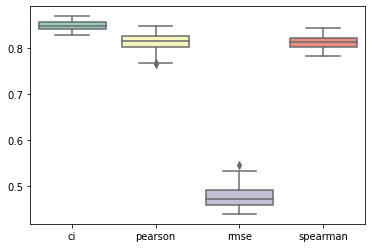

In [67]:
sns.boxplot(data=vertical_stack, palette="Set3")

In [73]:
df_melted = pd.melt(vertical_stack)

#view first 10 rows of melted data frame
df_melted.head(10)

,variable,value
0,ci,0.836616
1,ci,0.842262
2,ci,0.855547
3,ci,0.854010
4,ci,0.864884
5,ci,0.840821
6,ci,0.855628
7,ci,0.850695
8,ci,0.856649
9,ci,0.837040


In [ ]:
df_melted = pd.melt(vertical_stack)

In [75]:
df_melted

,variable,value
0,ci,0.836616
1,ci,0.842262
2,ci,0.855547
3,ci,0.854010
4,ci,0.864884
...,...,...
315,spearman,0.806854
316,spearman,0.806917
317,spearman,0.821744
318,spearman,0.797327


In [76]:
cmaps = ['pcons4'] * 160+['random']*160
cmaps

['pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',
 'pcons4',

In [77]:
df_melted['cmaps']=cmaps

<AxesSubplot:xlabel='variable', ylabel='value'>

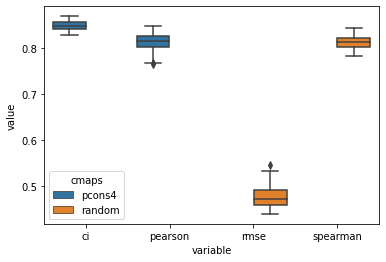

In [79]:
sns.boxplot(x='variable', y='value',hue='cmaps', data=df_melted)

In [19]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

/tmp/ipykernel_116456/2690038075.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


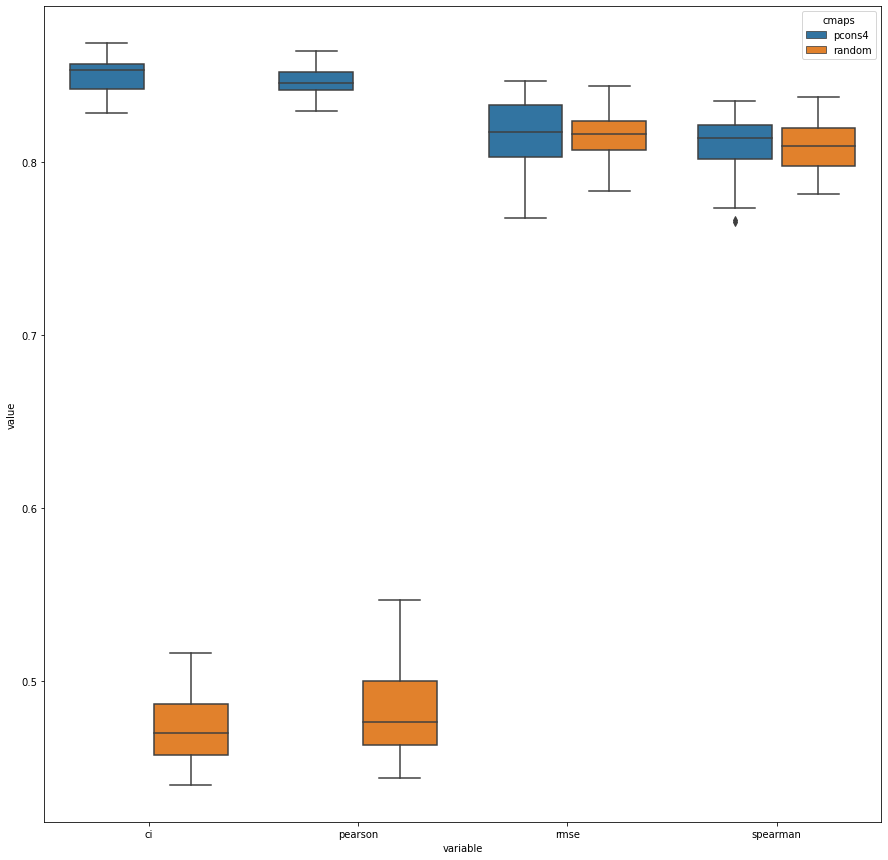

In [96]:
 fig = plt.figure(figsize=(15, 15))
bp = sns.boxplot(x='variable', y='value',hue='cmaps', data=df_melted)
adjust_box_widths(fig, 0.9)

In [94]:
cmaps1 = ['ci'] * 40+['pearson']*40+['rmse']*40+['spearman']*40+['ci'] * 40+['pearson']*40+['rmse']*40+['spearman']*40

In [86]:
df_melted[1:180]

,variable,value,cmaps
1,ci,0.842262,pcons4
2,ci,0.855547,pcons4
3,ci,0.854010,pcons4
4,ci,0.864884,pcons4
5,ci,0.840821,pcons4
...,...,...,...
175,rmse,0.493599,random
176,rmse,0.468804,random
177,rmse,0.486492,random
178,rmse,0.444485,random


In [89]:
df_melted.to_markdown()

'|     | variable   |    value | cmaps   |\n|----:|:-----------|---------:|:--------|\n|   0 | ci         | 0.836616 | pcons4  |\n|   1 | ci         | 0.842262 | pcons4  |\n|   2 | ci         | 0.855547 | pcons4  |\n|   3 | ci         | 0.85401  | pcons4  |\n|   4 | ci         | 0.864884 | pcons4  |\n|   5 | ci         | 0.840821 | pcons4  |\n|   6 | ci         | 0.855628 | pcons4  |\n|   7 | ci         | 0.850695 | pcons4  |\n|   8 | ci         | 0.856649 | pcons4  |\n|   9 | ci         | 0.83704  | pcons4  |\n|  10 | ci         | 0.86015  | pcons4  |\n|  11 | ci         | 0.852145 | pcons4  |\n|  12 | ci         | 0.849084 | pcons4  |\n|  13 | ci         | 0.855865 | pcons4  |\n|  14 | ci         | 0.854366 | pcons4  |\n|  15 | ci         | 0.83223  | pcons4  |\n|  16 | ci         | 0.848726 | pcons4  |\n|  17 | ci         | 0.85726  | pcons4  |\n|  18 | ci         | 0.859656 | pcons4  |\n|  19 | ci         | 0.855291 | pcons4  |\n|  20 | ci         | 0.846342 | pcons4  |\n|  21 | ci

In [90]:
pd.set_option('display.max_rows', 500)


In [91]:
df_melted

,variable,value,cmaps
0,ci,0.836616,pcons4
1,ci,0.842262,pcons4
2,ci,0.855547,pcons4
3,ci,0.854010,pcons4
4,ci,0.864884,pcons4
5,ci,0.840821,pcons4
6,ci,0.855628,pcons4
7,ci,0.850695,pcons4
8,ci,0.856649,pcons4
9,ci,0.837040,pcons4


In [183]:
rand_res['cmap']='random'

In [95]:
df_melted['variable']=cmaps1

In [97]:
pcons_res

,ci,pearson,rmse,spearman,cmap
0,0.836616,0.780921,0.497579,0.800984,pcons
1,0.842262,0.809381,0.499085,0.818261,pcons
2,0.855547,0.818042,0.455887,0.824221,pcons
3,0.854010,0.819140,0.494077,0.821747,pcons
4,0.864884,0.846482,0.439987,0.843546,pcons
5,0.840821,0.777199,0.497723,0.796605,pcons
6,0.855628,0.833973,0.447734,0.830768,pcons
7,0.850695,0.834527,0.458980,0.812848,pcons
8,0.856649,0.844047,0.441942,0.830297,pcons
9,0.837040,0.795681,0.463917,0.799880,pcons


In [195]:
vertical_stack = pd.concat([pcons_res, rand_res], axis=0)

In [196]:
vertical_stack

,ci,pearson,rmse,spearman,cmap
0,0.836616,0.780921,0.497579,0.800984,pconsc4
1,0.842262,0.809381,0.499085,0.818261,pconsc4
2,0.855547,0.818042,0.455887,0.824221,pconsc4
3,0.854010,0.819140,0.494077,0.821747,pconsc4
4,0.864884,0.846482,0.439987,0.843546,pconsc4
5,0.840821,0.777199,0.497723,0.796605,pconsc4
6,0.855628,0.833973,0.447734,0.830768,pconsc4
7,0.850695,0.834527,0.458980,0.812848,pconsc4
8,0.856649,0.844047,0.441942,0.830297,pconsc4
9,0.837040,0.795681,0.463917,0.799880,pconsc4


In [197]:
df_melted1 = pd.melt(vertical_stack, id_vars=["cmap"], value_vars=["ci", "pearson",'rmse','spearman'])

In [198]:
df_melted1 

,cmap,variable,value
0,pconsc4,ci,0.836616
1,pconsc4,ci,0.842262
2,pconsc4,ci,0.855547
3,pconsc4,ci,0.854010
4,pconsc4,ci,0.864884
5,pconsc4,ci,0.840821
6,pconsc4,ci,0.855628
7,pconsc4,ci,0.850695
8,pconsc4,ci,0.856649
9,pconsc4,ci,0.837040


/tmp/ipykernel_116456/2690038075.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


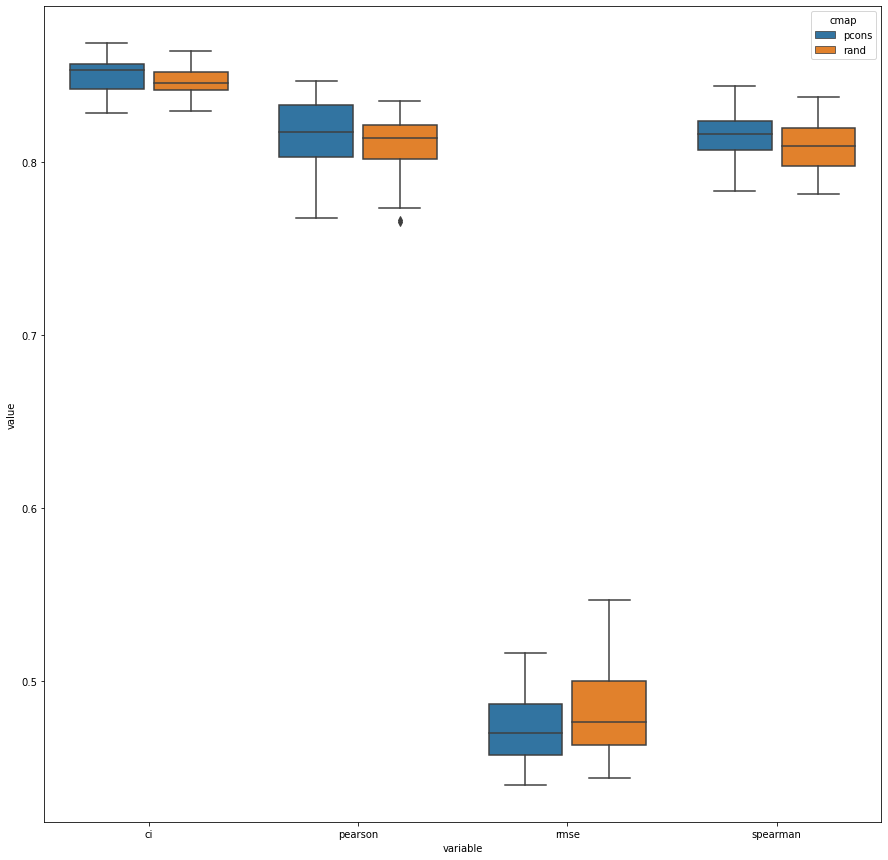

In [116]:
fig = plt.figure(figsize=(15, 15))
bp = sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1)


adjust_box_widths(fig, 0.9)

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pearson_pcons vs. pearson_rand: t-test paired samples, P_val:1.271e-01 t=1.559e+00
ci_pcons vs. ci_rand: t-test paired samples, P_val:4.009e-02 t=2.124e+00
rmse_pcons vs. rmse_rand: t-test paired samples, P_val:5.004e-02 t=-2.022e+00
spearman_pcons vs. spearman_rand: t-test paired samples, P_val:5.561e-02 t=1.973e+00


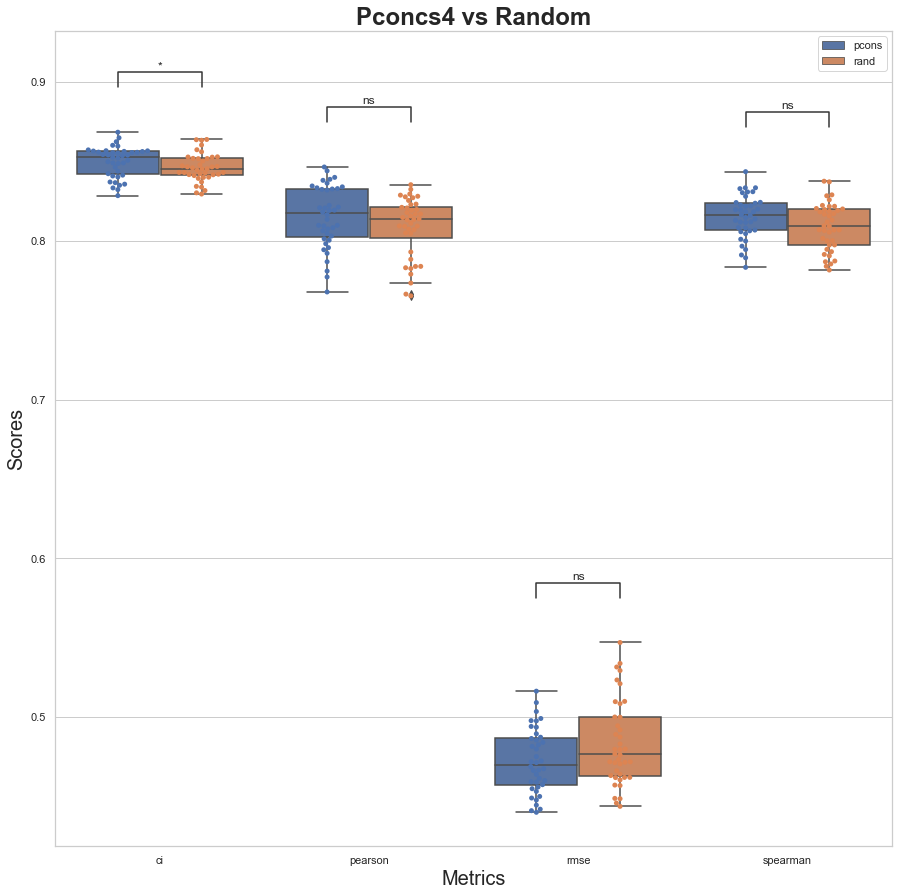

In [167]:
fig = plt.figure(figsize=(15, 15))
#bp = sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1)


adjust_box_widths(fig, 0.9)
hue_order=['pcons','rand']
order = ['ci', 'pearson','rmse','spearman']
pairs=[
    (("ci", "pcons"), ("ci", "rand")),
    (("rmse", "pcons"), ("rmse", "rand")),
    (("pearson", "pcons"), ("pearson", "rand")),
    (("spearman", "pcons"), ("spearman", "rand")),
    ]
ax=sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order)
sns.swarmplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order, split=True)
ax.set_xlabel('Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4 vs Random',fontsize=24,fontweight='bold')
annotator = Annotator(ax, pairs, data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')

annotator.apply_and_annotate()
# annotator.new_plot(ax, pairs,  data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
# annotator.configure(test='Mann-Whitney', verbose=2)
# annotator.apply_test()
# annotator.annotate()
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])


/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


pearson_pconsc4 vs. pearson_random: t-test paired samples, P_val:1.271e-01 t=1.559e+00
ci_pconsc4 vs. ci_random: t-test paired samples, P_val:4.009e-02 t=2.124e+00
rmse_pconsc4 vs. rmse_random: t-test paired samples, P_val:5.004e-02 t=-2.022e+00
spearman_pconsc4 vs. spearman_random: t-test paired samples, P_val:5.561e-02 t=1.973e+00


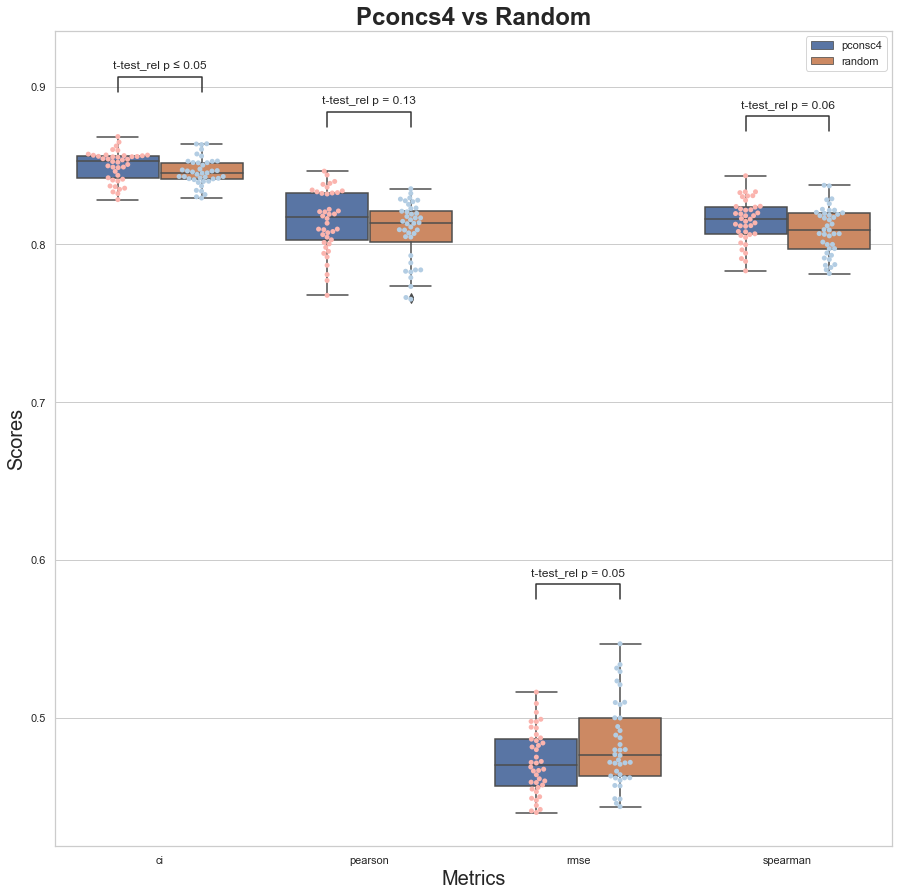

In [199]:
fig = plt.figure(figsize=(15, 15))

fig_args = {'x': 'variable',
            'y': 'value',
            'hue':'cmap',
            'data': df_melted1,
            'order': ['ci', 'pearson','rmse','spearman'],
            'hue_order':['pconsc4','random'],
            'dodge': True}
configuration = {'test':'t-test_paired',
                 'comparisons_correction':None,
                 'text_format':'star','loc':'inside'}

adjust_box_widths(fig, 0.9)
hue_order=['pconsc4','random']
order = ['ci', 'pearson','rmse','spearman']
pairs=[
    (("ci", "pconsc4"), ("ci", "random")),
    (("rmse", "pconsc4"), ("rmse", "random")),
    (("pearson", "pconsc4"), ("pearson", "random")),
    (("spearman", "pconsc4"), ("spearman", "random")),
    ]
ax =  sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order)
sns.swarmplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order,palette="Pastel1", split=True)
ax.set_xlabel('Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4 vs Random',fontsize=24,fontweight='bold')
annotator = Annotator(ax, pairs, data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
#annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
    .apply_test().annotate()
#annotator.apply_and_annotate()
# annotator.new_plot(ax, pairs,  data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
# annotator.configure(test='Mann-Whitney', verbose=2)
# annotator.apply_test()
# annotator.annotate()
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
fig.savefig(os.path.join('results',  'pconsc4_random' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'pconsc4_random' + '.pdf'), dpi=500, bbox_inches='tight')

In [147]:
sns.set_theme(style="whitegrid")

### plot1

In [175]:
esm_res=pd.read_csv('esm_res_plot1.csv')
esm_res

,ci,pearson,rmse,mse,rm,spearman
0,0.861535,0.824596,0.470693,0.221883,0.626595,0.827439
1,0.852179,0.818422,0.492103,0.242191,0.622887,0.822311
2,0.857462,0.831709,0.458916,0.210841,0.670885,0.828772
3,0.858525,0.809284,0.481080,0.231556,0.629867,0.825422
4,0.857697,0.818976,0.472546,0.223364,0.639121,0.827241
5,0.849689,0.827596,0.453291,0.205642,0.657492,0.812067
6,0.853736,0.801177,0.473702,0.224647,0.618529,0.825453
7,0.837768,0.814386,0.456449,0.208393,0.654357,0.800553
8,0.840313,0.802041,0.471999,0.222876,0.635442,0.813931
9,0.838294,0.781880,0.512408,0.262740,0.608632,0.781952


In [177]:
esm_res['cmap']='esm'

In [178]:
esm_res=esm_res.drop(columns='mse')

In [179]:
esm_res

,ci,pearson,rmse,spearman,cmap
0,0.861535,0.824596,0.470693,0.827439,esm
1,0.852179,0.818422,0.492103,0.822311,esm
2,0.857462,0.831709,0.458916,0.828772,esm
3,0.858525,0.809284,0.481080,0.825422,esm
4,0.857697,0.818976,0.472546,0.827241,esm
5,0.849689,0.827596,0.453291,0.812067,esm
6,0.853736,0.801177,0.473702,0.825453,esm
7,0.837768,0.814386,0.456449,0.800553,esm
8,0.840313,0.802041,0.471999,0.813931,esm
9,0.838294,0.781880,0.512408,0.781952,esm


In [193]:
pcons_res['cmap']='pconsc4'

In [194]:
pcons_res

,ci,pearson,rmse,spearman,cmap
0,0.836616,0.780921,0.497579,0.800984,pconsc4
1,0.842262,0.809381,0.499085,0.818261,pconsc4
2,0.855547,0.818042,0.455887,0.824221,pconsc4
3,0.854010,0.819140,0.494077,0.821747,pconsc4
4,0.864884,0.846482,0.439987,0.843546,pconsc4
5,0.840821,0.777199,0.497723,0.796605,pconsc4
6,0.855628,0.833973,0.447734,0.830768,pconsc4
7,0.850695,0.834527,0.458980,0.812848,pconsc4
8,0.856649,0.844047,0.441942,0.830297,pconsc4
9,0.837040,0.795681,0.463917,0.799880,pconsc4


In [200]:
vertical_stack1 = pd.concat([pcons_res, esm_res], axis=0)

In [201]:
df_melted1 = pd.melt(vertical_stack1, id_vars=["cmap"], value_vars=["ci", "pearson",'rmse','spearman'])

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


pearson_pconsc4 vs. pearson_esm: t-test paired samples, P_val:5.454e-01 t=-6.100e-01
ci_pconsc4 vs. ci_esm: t-test paired samples, P_val:3.447e-01 t=-9.565e-01
rmse_pconsc4 vs. rmse_esm: t-test paired samples, P_val:4.992e-01 t=6.821e-01
spearman_pconsc4 vs. spearman_esm: t-test paired samples, P_val:6.166e-01 t=-5.047e-01


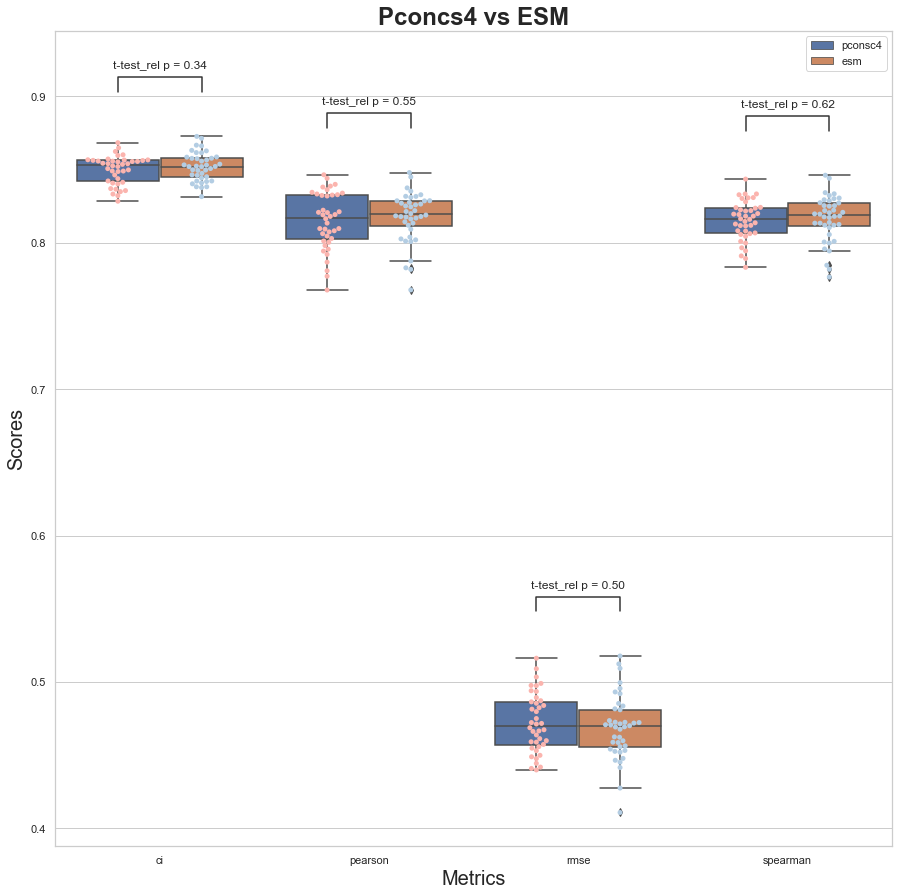

In [203]:
fig = plt.figure(figsize=(15, 15))

fig_args = {'x': 'variable',
            'y': 'value',
            'hue':'cmap',
            'data': df_melted1,
            'order': ['ci', 'pearson','rmse','spearman'],
            'hue_order':['pconsc4','esm'],
            'dodge': True}
configuration = {'test':'t-test_paired',
                 'comparisons_correction':None,
                 'text_format':'star','loc':'inside'}

adjust_box_widths(fig, 0.9)
hue_order=['pconsc4','esm']
order = ['ci', 'pearson','rmse','spearman']
pairs=[
    (("ci", "pconsc4"), ("ci", "esm")),
    (("rmse", "pconsc4"), ("rmse", "esm")),
    (("pearson", "pconsc4"), ("pearson", "esm")),
    (("spearman", "pconsc4"), ("spearman", "esm")),
    ]
ax =  sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order)
sns.swarmplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order,palette="Pastel1", split=True)
ax.set_xlabel('Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4 vs ESM',fontsize=24,fontweight='bold')
annotator = Annotator(ax, pairs, data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
#annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
    .apply_test().annotate()
#annotator.apply_and_annotate()
# annotator.new_plot(ax, pairs,  data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
# annotator.configure(test='Mann-Whitney', verbose=2)
# annotator.apply_test()
# annotator.annotate()
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
fig.savefig(os.path.join('results',  'pconsc4_esm' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'pconsc4_esm' + '.pdf'), dpi=500, bbox_inches='tight')

In [204]:
### Pconcs4 vs Alphafold

In [205]:
alpha_res=pd.read_csv('alpha_res_plot1.csv')
alpha_res

,ci,pearson,rmse,mse,rm,spearman
0,0.852496,0.807905,0.507034,0.257172,0.607873,0.809787
1,0.859502,0.826440,0.444986,0.198076,0.650950,0.816471
2,0.857819,0.850501,0.420172,0.176703,0.707962,0.833616
3,0.837292,0.802280,0.470796,0.221753,0.623325,0.783393
4,0.843277,0.828621,0.494838,0.246681,0.635927,0.813174
5,0.843778,0.802290,0.471094,0.222092,0.637890,0.806827
6,0.864142,0.818924,0.456474,0.208886,0.639252,0.824167
7,0.835587,0.807074,0.484554,0.234817,0.626999,0.807370
8,0.854791,0.817019,0.491850,0.241942,0.639468,0.819783
9,0.855854,0.790579,0.495636,0.245663,0.597970,0.817322


In [206]:
alpha_res['cmap']='alphafold'

In [208]:
alpha_res=alpha_res.drop(columns='rm')

In [209]:
vertical_stack1 = pd.concat([pcons_res, alpha_res], axis=0)

In [210]:
df_melted1 = pd.melt(vertical_stack1, id_vars=["cmap"], value_vars=["ci", "pearson",'rmse','spearman'])

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


pearson_pconsc4 vs. pearson_alphafold: t-test paired samples, P_val:6.284e-01 t=4.879e-01
ci_pconsc4 vs. ci_alphafold: t-test paired samples, P_val:1.383e-01 t=1.513e+00
rmse_pconsc4 vs. rmse_alphafold: t-test paired samples, P_val:5.878e-01 t=-5.466e-01
spearman_pconsc4 vs. spearman_alphafold: t-test paired samples, P_val:1.989e-01 t=1.307e+00


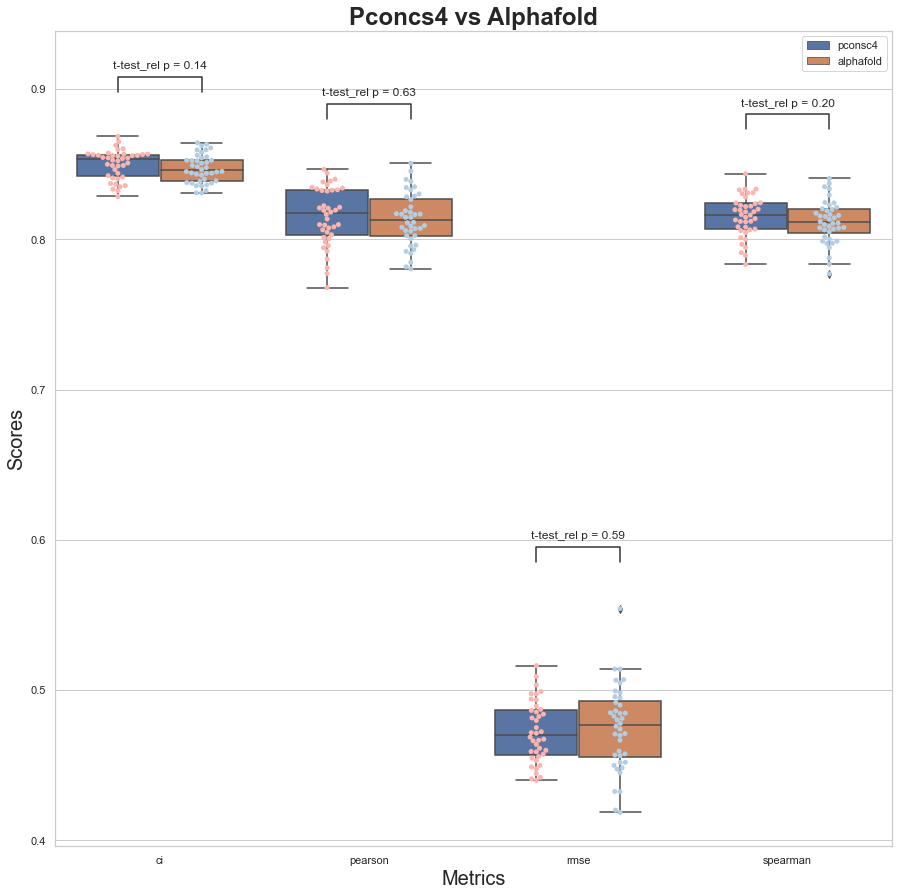

In [212]:
fig = plt.figure(figsize=(15, 15))

fig_args = {'x': 'variable',
            'y': 'value',
            'hue':'cmap',
            'data': df_melted1,
            'order': ['ci', 'pearson','rmse','spearman'],
            'hue_order':['pconsc4','alphafold'],
            'dodge': True}
configuration = {'test':'t-test_paired',
                 'comparisons_correction':None,
                 'text_format':'star','loc':'inside'}

adjust_box_widths(fig, 0.9)
hue_order=['pconsc4','alphafold']
order = ['ci', 'pearson','rmse','spearman']
pairs=[
    (("ci", "pconsc4"), ("ci", "alphafold")),
    (("rmse", "pconsc4"), ("rmse", "alphafold")),
    (("pearson", "pconsc4"), ("pearson", "alphafold")),
    (("spearman", "pconsc4"), ("spearman", "alphafold")),
    ]
ax =  sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order)
sns.swarmplot(x='variable', y='value',hue='cmap', data=df_melted1, order=order,  hue_order=hue_order,palette="Pastel1", split=True)
ax.set_xlabel('Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4 vs Alphafold',fontsize=24,fontweight='bold')
annotator = Annotator(ax, pairs, data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
#annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
    .apply_test().annotate()
#annotator.apply_and_annotate()
# annotator.new_plot(ax, pairs,  data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
# annotator.configure(test='Mann-Whitney', verbose=2)
# annotator.apply_test()
# annotator.annotate()
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
fig.savefig(os.path.join('results',  'pconsc4_alphafold' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'pconsc4_alphafold' + '.pdf'), dpi=500, bbox_inches='tight')

In [15]:
vertical_stack2 = pd.concat([pcons_res, rand_mol_res], axis=0)

In [16]:
df_melted2= pd.melt(vertical_stack2, id_vars=["cmap"], value_vars=["ci", "pearson",'rmse','spearman'])

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


pearson_Original_Mol_Graph vs. pearson_Random_Mol_Graph: t-test paired samples, P_val:9.823e-58 t=1.714e+02
ci_Original_Mol_Graph vs. ci_Random_Mol_Graph: t-test paired samples, P_val:6.855e-49 t=1.016e+02
rmse_Original_Mol_Graph vs. rmse_Random_Mol_Graph: t-test paired samples, P_val:2.585e-48 t=-9.815e+01
spearman_Original_Mol_Graph vs. spearman_Random_Mol_Graph: t-test paired samples, P_val:3.495e-56 t=1.564e+02


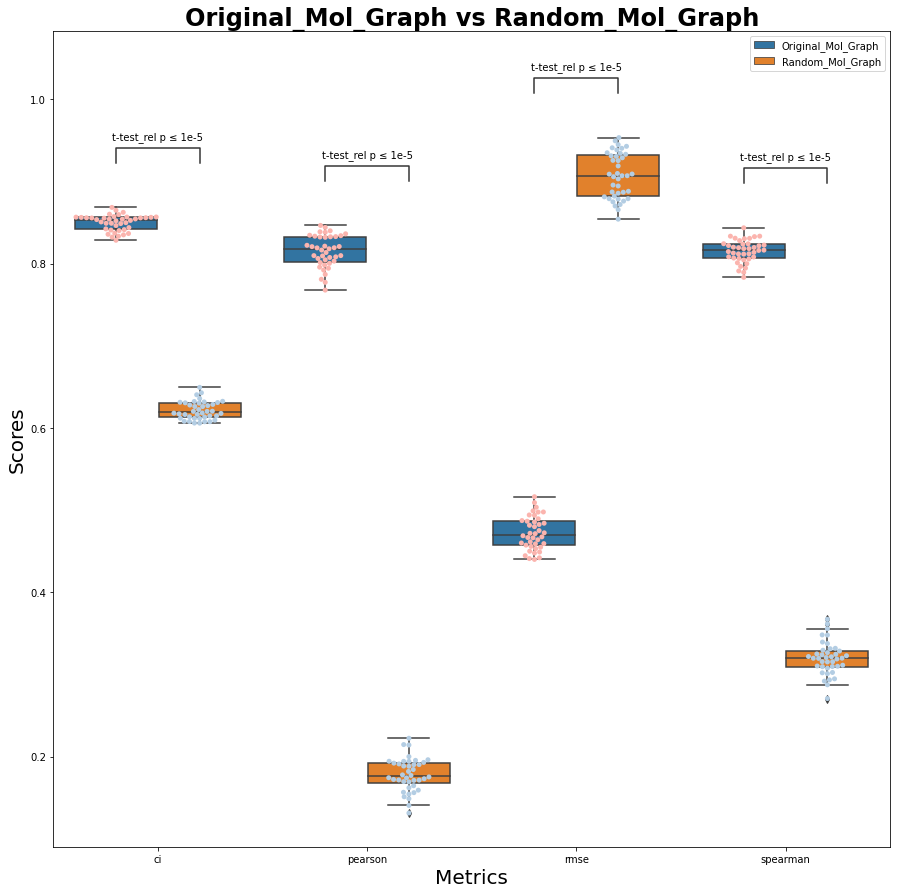

In [23]:
fig = plt.figure(figsize=(15, 15))

fig_args = {'x': 'variable',
            'y': 'value',
            'hue':'cmap',
            'data': df_melted2,
            'order': ['ci', 'pearson','rmse','spearman'],
            'hue_order':['Original_Mol_Graph','Random_Mol_Graph'],
            'dodge': True}
configuration = {'test':'t-test_paired',
                 'comparisons_correction':None,
                 'text_format':'star','loc':'inside'}

adjust_box_widths(fig, 0.9)
hue_order=['Original_Mol_Graph','Random_Mol_Graph']
order = ['ci', 'pearson','rmse','spearman']
pairs=[
    (("ci", "Original_Mol_Graph"), ("ci", "Random_Mol_Graph")),
    (("rmse", "Original_Mol_Graph"), ("rmse", "Random_Mol_Graph")),
    (("pearson", "Original_Mol_Graph"), ("pearson", "Random_Mol_Graph")),
    (("spearman", "Original_Mol_Graph"), ("spearman", "Random_Mol_Graph")),
    ]
ax =  sns.boxplot(x='variable', y='value',hue='cmap', data=df_melted2, order=order,  hue_order=hue_order)
sns.swarmplot(x='variable', y='value',hue='cmap', data=df_melted2, order=order,  hue_order=hue_order,palette="Pastel1", split=True)
ax.set_xlabel('Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Original_Mol_Graph vs Random_Mol_Graph',fontsize=24,fontweight='bold')
annotator = Annotator(ax, pairs, data=df_melted2, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
#annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
    .apply_test().annotate()
#annotator.apply_and_annotate()
# annotator.new_plot(ax, pairs,  data=df_melted1, x='variable', y='value', order=order, hue='cmap', hue_order=hue_order)
# annotator.configure(test='Mann-Whitney', verbose=2)
# annotator.apply_test()
# annotator.annotate()
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('example_hue_layout.png', dpi=300, bbox_inches='tight')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
fig.savefig(os.path.join('results',  'Original_Mol_Graph vs Random_Mol_Graph' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'Original_Mol_Graph vs Random_Mol_Graph' + '.pdf'), dpi=500, bbox_inches='tight')